In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, "/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
import lifelines

from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from scipy.stats import pearsonr, spearmanr, mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [2]:
### STATS ###
import statsmodels.stats.multitest as multi
from matplotlib.collections import PatchCollection

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Get survival information

In [4]:
def make_df(surv,surv_type,raw):
    #get survival dataframe
    surv=pd.read_csv(surv,index_col=0)
    surv=surv.rename(columns={"bcr_patient_barcode":"FID"})
    #get genotypes
    snps=pd.read_csv(raw,delimiter=" ")
    cols=[x for x in snps.columns if x not in ["IID","PAT","MAT","SEX","PHENOTYPE"]]
    snps=snps[cols]
    #combine dataframes
    full_surv=pd.merge(surv[["FID",surv_type,surv_type+".time","age_at_initial_pathologic_diagnosis","race","gender","ajcc_pathologic_tumor_stage"]],snps,on="FID")
    #full_surv=full_surv[full_surv[surv_type+".time"]<1825] #censor at 5 years
    print(full_surv.shape)
    return(full_surv)

In [5]:
os_surv=make_df("/cellar/users/mpagadal/Data/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv","OS","/nrnb/users/mpagadal/tcga-genotypes/germline-immune/hla.snp.raw")

(8183, 112)


## Get cancer mapping

In [6]:
# map to cancer type
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
os_surv["cancer"]=os_surv["FID"].map(mp)

## Get stage information

In [314]:
# #get patients with Stage designations
# comb_surv_pheno=os_surv[os_surv["ajcc_pathologic_tumor_stage"].str.contains("Stage")]
# comb_surv_pheno=comb_surv_pheno[~(comb_surv_pheno["ajcc_pathologic_tumor_stage"].isin(["Stage X"]))]

# #split A,B,C from stage designations
# comb_surv_pheno["ajcc_pathologic_tumor_stage"]=comb_surv_pheno["ajcc_pathologic_tumor_stage"].str.split("A").str[0]
# comb_surv_pheno["ajcc_pathologic_tumor_stage"]=comb_surv_pheno["ajcc_pathologic_tumor_stage"].str.split("B").str[0]
# comb_surv_pheno["ajcc_pathologic_tumor_stage"]=comb_surv_pheno["ajcc_pathologic_tumor_stage"].str.split("C").str[0]

# #comb_surv_pheno=comb_surv_pheno.join(pd.get_dummies(comb_surv_pheno["ajcc_pathologic_tumor_stage"]))

In [315]:
# comb_surv_pheno['ajcc_pathologic_tumor_stage'] = comb_surv_pheno['ajcc_pathologic_tumor_stage'].replace({'Stage I': 1,'Stage II': 2,'Stage III': 3,'Stage IV': 4})

In [316]:
# os_surv_cesc=os_surv[os_surv["cancer"]=="CESC"]

In [317]:
# comb_surv_pheno=comb_surv_pheno.append(os_surv_cesc)

In [318]:
# comb_surv_pheno['ajcc_pathologic_tumor_stage']=comb_surv_pheno['ajcc_pathologic_tumor_stage'].replace("[Not Available]",0)

## Get HLA-A combinations

In [7]:
comb_surv_pheno=os_surv

In [8]:
comb_surv_pheno["6:29933439:T:C_T"]=comb_surv_pheno["6:29933439:T:C_C"].map({2:0,1:1,0:2})

In [9]:
combo=[]

for i,row in comb_surv_pheno.iterrows():
    if (row["6:29933439:T:C_T"]>0) & (row["6:29910358:G:C_C"]>0):
        combo.append(2)
    elif row["6:29933439:T:C_T"]>0:
        combo.append(1)
    elif row["6:29910358:G:C_C"]>0:
        combo.append(1)
    else:
        combo.append(0)
        
comb_surv_pheno["combo"]=combo 

## Get sex mapping

In [10]:
comb_surv_pheno["gender"]= comb_surv_pheno['gender'].replace({'MALE': 0,'FEMALE':1})

## Viral Status

In [11]:
cesc=pd.read_csv("/cellar/users/andreabc/Data/TCGA/clinical/nationwidechildrens.org_clinical_patient_cesc.txt",delimiter="\t")

In [12]:
cesc_hpv=cesc[cesc["hpv_types_positive"].str.contains("HPV")]["bcr_patient_barcode"].tolist()

In [13]:
lihc=pd.read_csv("/cellar/users/andreabc/Data/TCGA/clinical/nationwidechildrens.org_clinical_patient_lihc.txt",delimiter="\t")

In [14]:
lihc_hbvhcv=lihc[lihc["viral_hepatitis_serology"].str.contains("H")]["bcr_patient_barcode"].tolist()

In [15]:
hnsc=pd.read_csv("/cellar/users/andreabc/Data/TCGA/clinical/nationwidechildrens.org_clinical_patient_hnsc.txt",delimiter="\t")

In [16]:
hnsc_hpv=hnsc[hnsc["hpv_status_p16"].str.contains("Positive")]["bcr_patient_barcode"].tolist()

## Get Michelle viral status

In [17]:
import pickle

In [19]:
viral=pd.read_pickle("/cellar/users/mdow/Projects/Viral/processed_data/all_viral_stats.pkl")

In [41]:
viral=viral[viral["Viral"]=="positive"]["PID"].tolist()

In [33]:
comb_surv_pheno["PID"]=comb_surv_pheno["FID"].str.split("-").str[2]

In [35]:
comb_surv_pheno["PID"]=comb_surv_pheno["PID"].str.lower()

## Map Viral Status

In [36]:
comb_surv_pheno["cancer viral"]=np.where(comb_surv_pheno["FID"].isin(cesc_hpv),"CESC HPV+",comb_surv_pheno["cancer"])
comb_surv_pheno["cancer viral"]=np.where(comb_surv_pheno["FID"].isin(lihc_hbvhcv),"LIHC HBV/HCV+",comb_surv_pheno["cancer viral"])
comb_surv_pheno["cancer viral"]=np.where(comb_surv_pheno["FID"].isin(hnsc_hpv),"HNSC HPV+",comb_surv_pheno["cancer viral"])

In [42]:
comb_surv_pheno["virus"]=np.where(comb_surv_pheno["PID"].isin(viral),"+","-")

In [45]:
comb_surv_pheno["cancer viral2"]=comb_surv_pheno["cancer"]+comb_surv_pheno["virus"]

## Remove null variables

In [46]:
comb_surv_pheno=comb_surv_pheno[~comb_surv_pheno["age_at_initial_pathologic_diagnosis"].isnull()]
comb_surv_pheno=comb_surv_pheno[~comb_surv_pheno["OS"].isnull()]
comb_surv_pheno=comb_surv_pheno[~comb_surv_pheno["OS.time"].isnull()]

In [47]:
cancers=comb_surv_pheno["cancer viral2"].unique().tolist()

In [49]:
comb_surv_pheno["cancer viral2"].value_counts()

BRCA-    792
OV-      492
LUSC-    438
SKCM-    432
LGG-     429
LUAD-    423
KIRC-    421
GBM-     406
PRAD-    401
UCEC-    367
THCA-    361
COAD-    340
HNSC-    331
BLCA-    325
STAD-    277
SARC-    219
KIRP-    204
CESC+    164
PAAD-    154
PCPG-    144
LIHC-    138
READ-    135
ESCA-    119
TGCT-    108
HNSC+     88
ACC-      82
MESO-     81
UVM-      77
KICH-     54
UCS-      42
LIHC+     34
CHOL-     30
CESC-     14
Name: cancer viral2, dtype: int64

In [53]:
disease_df = pd.DataFrame()

for disease in cancers:
    print(disease)
    if disease in ["BRCA-","TGCT-","PRAD-","OV-","UCEC-","UCS-"]:
        temp_df = comb_surv_pheno[comb_surv_pheno['cancer viral2']==disease]
        temp_df = temp_df[['age_at_initial_pathologic_diagnosis','combo','OS','OS.time']]
        cph = CoxPHFitter()
        cph.fit(temp_df, event_col='OS', duration_col='OS.time')
        cph.summary["cancer"]=disease
        disease_df = disease_df.append(cph.summary.loc[["combo"]])
    elif disease in ["CESC-","CESC+"]:
        temp_df = comb_surv_pheno[comb_surv_pheno['cancer viral2']==disease]
        temp_df = temp_df[['age_at_initial_pathologic_diagnosis','combo','OS','OS.time']]
        cph = CoxPHFitter()
        cph.fit(temp_df, event_col='OS', duration_col='OS.time')
        cph.summary["cancer"]=disease
        disease_df = disease_df.append(cph.summary.loc[["combo"]])
        
    else:
        temp_df = comb_surv_pheno[comb_surv_pheno['cancer viral2']==disease]
        temp_df = temp_df[['age_at_initial_pathologic_diagnosis','gender','combo','OS','OS.time']]
        cph = CoxPHFitter()
        cph.fit(temp_df, event_col='OS', duration_col='OS.time')
        cph.summary["cancer"]=disease
        disease_df = disease_df.append(cph.summary.loc[["combo"]])

disease_df["cancer"]=cancers


ACC-
BLCA-
BRCA-
CESC-
CESC+
CHOL-
COAD-
ESCA-
GBM-
HNSC-
HNSC+
KICH-
KIRC-
KIRP-
LGG-
LIHC+
LIHC-
LUAD-
LUSC-
MESO-
OV-
PAAD-
PCPG-
PRAD-
READ-
SARC-
SKCM-
STAD-
TGCT-
THCA-
UCEC-
UCS-
UVM-


In [345]:
disease_df = pd.DataFrame()

for disease in cancers:
    print(disease)
    if disease in ["BRCA","TGCT","PRAD","OV"]:
        temp_df = comb_surv_pheno[comb_surv_pheno['cancer viral']==disease]
        temp_df = temp_df[['age_at_initial_pathologic_diagnosis','ajcc_pathologic_tumor_stage','combo','OS','OS.time']]
        cph = CoxPHFitter()
        cph.fit(temp_df, event_col='OS', duration_col='OS.time')
        cph.summary["cancer"]=disease
        disease_df = disease_df.append(cph.summary.loc[["combo"]])
    elif disease in ["CESC","CESC HPV+"]:
        temp_df = comb_surv_pheno[comb_surv_pheno['cancer viral']==disease]
        temp_df = temp_df[['age_at_initial_pathologic_diagnosis','combo','OS','OS.time']]
        cph = CoxPHFitter()
        cph.fit(temp_df, event_col='OS', duration_col='OS.time')
        cph.summary["cancer"]=disease
        disease_df = disease_df.append(cph.summary.loc[["combo"]])
        
    else:
        temp_df = comb_surv_pheno[comb_surv_pheno['cancer viral']==disease]
        temp_df = temp_df[['age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage','combo','OS','OS.time']]
        cph = CoxPHFitter()
        cph.fit(temp_df, event_col='OS', duration_col='OS.time')
        cph.summary["cancer"]=disease
        disease_df = disease_df.append(cph.summary.loc[["combo"]])

disease_df["cancer"]=cancers


ACC


ValueError: could not convert string to float: 'Stage IV'

In [54]:
disease_df["neg"]=disease_df["exp(coef)"]-disease_df["exp(coef) lower 95%"]
disease_df["pos"]=disease_df["exp(coef) upper 95%"]-disease_df["exp(coef)"]

In [55]:
disease_df=disease_df[disease_df["cancer"]!="TGCT"]

In [56]:
disease_df=disease_df.sort_values(by="exp(coef)")

In [57]:
disease_df.sort_values(by="p")

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p),cancer,neg,pos
combo,0.516133,1.675536,0.255421,0.015517,1.016749,1.015638,2.764194,2.020715,0.043309,4.529181,UCEC-,0.659898,1.088658
combo,0.351282,1.420888,0.191495,-0.024041,0.726605,0.976246,2.068048,1.834423,0.066591,3.908523,PAAD-,0.444642,0.647160
combo,-0.266047,0.766403,0.151615,-0.563206,0.031112,0.569381,1.031602,-1.754756,0.079301,3.656517,STAD-,0.197023,0.265198
combo,3.190590,24.302750,2.240416,-1.200545,7.581724,0.301030,1962.007790,1.424106,0.154416,2.695108,CESC-,24.001720,1937.705039
combo,0.397370,1.487906,0.300148,-0.190910,0.985649,0.826207,2.679551,1.323913,0.185532,2.430260,ACC-,0.661699,1.191645
combo,-0.134041,0.874554,0.109516,-0.348689,0.080607,0.705612,1.083945,-1.223938,0.220976,2.178041,SKCM-,0.168942,0.209391
combo,-0.408977,0.664329,0.381827,-1.157344,0.339390,0.314320,1.404090,-1.071107,0.284121,1.815420,UVM-,0.350009,0.739761
combo,-0.718436,0.487514,0.708602,-2.107269,0.670398,0.121569,1.955015,-1.013878,0.310641,1.686681,LIHC+,0.365945,1.467501
combo,-0.218848,0.803444,0.224200,-0.658272,0.220575,0.517745,1.246793,-0.976131,0.328999,1.603843,ESCA-,0.285698,0.443350
combo,0.155988,1.168812,0.161914,-0.161357,0.473333,0.850988,1.605336,0.963402,0.335346,1.576279,LGG-,0.317824,0.436524


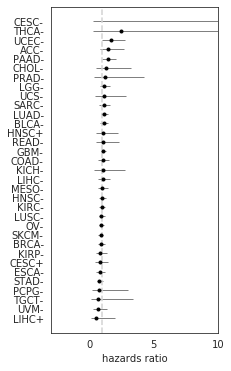

In [58]:
fig, ax = plt.subplots(figsize=(3, 6))
plt.errorbar(disease_df["exp(coef)"].tolist(),disease_df["cancer"].tolist(),xerr=disease_df[["neg","pos"]].T.values, fmt='.', color='black',
             ecolor='gray', elinewidth=1);
plt.axvline(1,linestyle="--",color="lightgray")
plt.xlabel("hazards ratio")
plt.xlim([-3,10])
plt.savefig("../plots/hazards.ratio.pdf")